# Figure 1. Sex-biased gene expression and alternative splicing. 

- (a) Pre-messenger RNA splicing occurs cotranscriptionally and is influenced by RNA binding proteins and epigenetic factors such as histone modifications that interact with the transcriptional machinery or other proteins to influence splicing and transcription.17 
- (b) Flowchart depicting the analysis of GTEx RNA-seq data. Analysis of GTEx gene expression and AS profiles identified significantly sex-biased genes and AS events. Data were used as input for a hierarchical Bayesian model to characterize the influence of RBPs and gene expression on sex-biased AS events. 
- **(c) Heatplot representing similarity in the fold-changes between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues.**

- (d) The five categories of AS events that were investigated in this work <br>(**`SE`**: skipped exon/exon inclusion; **`A3SS/A5SS`**: alternative 3’/5’ splice site; **`MEX`**: mutually exclusive exons; **`RI`**: retained intron). 

- **(e) Number of sex-biased AS events per tissue type.**

A `heatplot` representing similarity in the fold-changes between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues. </b>

## **NOTE**:

We assume that you have cloned the analysis repository and have `cd` into the parent directory. Before starting with the analysis make sure you have first completed the dependencies set up by following the instructions described in the **`dependencies/README.md`** document. All paths defined in this Notebook are relative to the parent directory (repository). Please close this Notebook and start again by following the above guidelines if you have not completed the aforementioned steps.

## Loading dependencies

In [1]:
library(downloader)
library(readr)
library(edgeR)
library(biomaRt)
library(DBI) # v >= 1.1.0 required for biomaRt
library(devtools)
library(yarn)
library(statmod)
library(piggyback)
library(snakecase)
library(stringr)
library(pheatmap)
library(magrittr)
library(dplyr)
library(ggplot2)
library(scales)
library(viridis)
library(scales)

Sys.setenv(TAR = "/bin/tar") # for gzfile

Loading required package: limma
Warning message:
“package ‘DBI’ was built under R version 3.6.2”Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdi

ERROR: Error: package or namespace load failed for ‘yarn’ in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]):
 there is no package called ‘plyr’


## Figure 1c  Heatplot representing similarity in the fold-changes between male and female samples
The values in the heatmap being the correlation between the vectors of fold changes of the tissues.

# Retrieving the GTEx archive

We used the R package [{yarn}](https://bioconductor.org/packages/release/bioc/html/yarn.html) to retrieve the GTEx Biobank data. In order to downloaded the latest GTEx version 8.0 for RNA-seq and genotype data (phs000424.v8.v2), released 2019-08-26, we created a fork of the package's GitHub repository and created a new version of the function **`yarn::downloadGTEx()`**, namely **`yarn::downloadGTExV8()`** to download this release. 

We used the function to perform quality control, gene filtering and normalization pre-processing on the GTEx RNA-seq data, as described in (Paulson et al, 2017). This pipeline tested for sample sex-misidentification, merged related sub-tissues and performed tissue-aware normalization using the **`{yarn::qsmooth}`**  function (Hicks et al, 2017).

We have archived the output of the **`yarn::downloadGTExV8()`** function, which is an `ExpressionSet` object in the repo `lifebitai/lifebitCloudOSDREgtex` for replicability and decreasing the runtime of this analysis. Below we retrieve this `gtex.rds` object from the GitHub releases using the **`{ropensci/piggyback}`** package, but we have also added the relevant command to retrieve the data from GTEx and generate the `ExpressionSet` object using  **`yarn::downloadGTExV8()`**. For the current analysis we are utilising a compute resource with 8 vCPUs and 60 GB of memory available.



In [2]:
# Load with readRDS() if gtex.rds available in data/
if ("gtex.rds" %in% list.files("../data/")) {
    message("Loading GTEx v8 rds object with readRDS from ../data/gtex.rds ..\n")   
    obj <- readRDS(file = "../data/gtex.rds")
    message("Done!\n")
    message("Generating sha256sum for gtex.rds ..\n")    
    message(system("sha256sum ../data/gtex.rds", intern = TRUE))
    message("Done!\n")
}

# Download from archive if not available in ../data
if (!("gtex.rds" %in% list.files("../data/"))) {
    message("Downloading GTEx v8 from GitHub Releases archive into the ../data/ directory ..\n")
    piggyback::pb_download(file = "gtex.rds", 
                                repo = "lifebit-ai/lifebitCloudOSDREgtex", 
                                tag  = "fig1c_archive", 
                                dest = "../data/")
    message("Generating sha256sum for gtex.rds ..")    
    message(system("sha256sum ../data/gtex.rds", intern = TRUE))
    message("Done!\n")    
    message("Loading GTEx v8 rds object with readRDS from ../data/gtex.rds ..\n")    
    obj <- readRDS(file = "../data/gtex.rds" )
    message("Done!\n")
}

# Download with yarn if you wish, this requires several minutes to complete
if (!("gtex.rds" %in% list.files("../data/"))) {
    message("Downloading GTEx v8 with 'yarn::downloadGTExV8()'")
    obj <- yarn::downloadGTExV8(type='genes',file='../data/gtex.rds')
    message("Done!")

}

Loading GTEx v8 rds object with readRDS from ../data/gtex.rds ..

Done!

Generating sha256sum for gtex.rds ..

18e2c7a83c98dcf59ddab53e1281923979d49da6ea3acb68114c5a44057c57bc  ../data/gtex.rds
Done!



In [3]:
# Confirm that it is an expression set.
# and check the dimensions of the objects, and the phenotype information of the objects
class(obj) 
dim(phenoData(obj))
dim(obj)

[1] "ExpressionSet"
attr(,"package")
[1] "Biobase"

rowNames columnNames 
      17384          67

Features  Samples 
   55878    17382

### NOTE: 

We observe above that our phenotype data have 2 more observations than our expression data,  let's inspect what are these samples:

In [4]:
sample_names=as.vector(as.character(colnames(exprs(obj))))
length(sample_names)

pheno_sample_names=as.vector(as.character(rownames(pData(obj))))
length(pheno_sample_names)

if (length(pheno_sample_names) > length(sample_names)) {
    superset <- pheno_sample_names
    subset   <- sample_names    
} 

if (length(pheno_sample_names) < length(sample_names)) {
    superset <- sample_names
    subset   <- pheno_sample_names   
} 

non_overlaps <- setdiff( superset, subset)

message("The non-overlapping IDs between pheno and count data are:\n\n", 
        paste(non_overlaps, collapse = "\n") )

[1] 17382

[1] 17384

The non-overlapping IDs between pheno and count data are:

GTEX-YF7O-2326-101833-SM-5CVN9
GTEX-YEC3-1426-101806-SM-5PNXX


Let's keep only the overlapping IDs:

In [5]:
logical_match_names=pheno_sample_names %in% sample_names
length(logical_match_names)
table(logical_match_names)
pData(obj) <- (pData(obj)[logical_match_names==TRUE,])
dim(pData(obj))
dim(obj)

[1] 17384

logical_match_names
FALSE  TRUE 
    2 17382 

[1] 17382    67

Features  Samples 
   55878    17382

In [6]:
install.packages("R.utils")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [7]:
library(R.utils)

Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.8.0 (2020-02-14 07:10:20 UTC) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.23.0 successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following object is masked from ‘package:R.methodsS3’:

    throw

The following objects are masked from ‘package:devtools’:

    check, unload

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, load, save

R.utils v2.9.2 successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, inherits, isOpen, nullfile, parse,
    warnings



We have currently all of our runs from rMATS stored with the SRR number - this maps to the annotation via the SraRunTable$biospecimen_repository_sample_id. 

What we will do here for scalling is read all the inc for this step, and then we will add a separate step for ijc/sjc analysis for comparison purposes.

This step assumes that you either mounted the data from the bucket or you have used (after installing, the gsutil tools from google (on a google platform) or aws cli tools (on an amazon platform).  Or the equivalent on an Azure platform

In [8]:
se.jc.inc <- data.table::fread("../data/rmats_final.se.jc.inc.txt.gz") 

In [97]:
se.jcec.inc <- data.table::fread("../data/rmats_final.se.jcec.inc.txt.gz") 

In [ ]:
ri.jc.inc <- data.table::fread("../data/rmats_final.ri.jc.inc.txt.gz")

In [ ]:
ri.jcec.inc <- data.table::fread("../data/rmats_final.ri.jcec.inc.txt.gz")

In [ ]:
mxe.jc.inc <- data.table::fread("../data/rmats_final.mxe.jc.inc.txt.gz")

In [ ]:
mxe.jcec.inc <- data.table::fread("../data/rmats_final.mxe.jcec.inc.txt.gz")

In [ ]:
a3ss.jc.inc <- data.table::fread("../data/rmats_final.a3ss.jc.inc.txt.gz")

In [ ]:
a3ss.jcec.inc <- data.table::fread("../data/rmats_final.a3ss.jc.inc.txt.gz")

In [9]:
dim(se.jc.inc)

[1] 42611  8674

In [10]:
head (se.jc.inc)

ID,SRR1068788,SRR1068808,SRR1068832,SRR1068855,SRR1068880,SRR1068929,SRR1068953,SRR1068977,SRR1068999,⋯,SRR821573,SRR821581,SRR821602,SRR821626,SRR821653,SRR821690,SRR821715,SRR823967,SRR823991,SRR824015
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0000,0.0000,0.000,0.0000,0.0769,0.0000,0.0000,0,0.0000,⋯,0.0000,0.000,0,0.0,0.0000,0,0.0000,0,0,0
2,1.0000,1.0000,1.000,0.9972,1.0000,1.0000,0.9885,1,1.0000,⋯,1.0000,1.000,1,1.0,1.0000,1,1.0000,1,1,1
3,1.0000,0.0000,1.000,0.0000,0.0000,0.0000,1.0000,1,1.0000,⋯,1.0000,1.000,0,1.0,1.0000,0,1.0000,0,0,0
4,0.0000,1.0000,1.000,0.5000,0.0000,0.0000,1.0000,0,0.5000,⋯,0.0000,0.000,0,0.0,0.2000,0,0.0000,0,0,0
5,1.0000,0.0000,0.250,0.1578,0.4285,1.0000,0.1428,1,0.4545,⋯,0.1428,0.250,0,0.2,0.5000,0,0.5000,0,0,0
6,0.0833,0.0041,0.027,0.0087,0.0142,0.0082,0.0078,0,0.0084,⋯,0.0095,0.037,0,0.0,0.0058,0,0.0078,0,0,0


#  Now we want to replace all *dashes* with **dots "."**

In [11]:
pData(obj)$SAMPID[1]
pData(obj)$SAMPID                            <- gsub('-','\\.',pData(obj)$SAMPID)
pData(obj)$SAMPID[1]

GTEX-1117F-0226-SM-5GZZ7 
GTEX-1117F-0226-SM-5GZZ7 
22951 Levels: GTEX-1117F-0003-SM-58Q7G ... K-562-SM-E9EZZ

[1] "GTEX.1117F.0226.SM.5GZZ7"

In [12]:
colnames(pData(obj))

[1] "SAMPID"    "SMATSSCR"  "SMCENTER"  "SMPTHNTS"  "SMRIN"     "SMTS"     
 [7] "SMTSD"     "SMUBRID"   "SMTSISCH"  "SMTSPAX"   "SMNABTCH"  "SMNABTCHT"
[13] "SMNABTCHD" "SMGEBTCH"  "SMGEBTCHD" "SMGEBTCHT" "SMAFRZE"   "SMGTC"    
[19] "SME2MPRT"  "SMCHMPRS"  "SMNTRART"  "SMNUMGPS"  "SMMAPRT"   "SMEXNCRT" 
[25] "SM550NRM"  "SMGNSDTC"  "SMUNMPRT"  "SM350NRM"  "SMRDLGTH"  "SMMNCPB"  
[31] "SME1MMRT"  "SMSFLGTH"  "SMESTLBS"  "SMMPPD"    "SMNTERRT"  "SMRRNANM" 
[37] "SMRDTTL"   "SMVQCFL"   "SMMNCV"    "SMTRSCPT"  "SMMPPDPR"  "SMCGLGTH" 
[43] "SMGAPPCT"  "SMUNPDRD"  "SMNTRNRT"  "SMMPUNRT"  "SMEXPEFF"  "SMMPPDUN" 
[49] "SME2MMRT"  "SME2ANTI"  "SMALTALG"  "SME2SNSE"  "SMMFLGTH"  "SME1ANTI" 
[55] "SMSPLTRD"  "SMBSMMRT"  "SME1SNSE"  "SME1PCTS"  "SMRRNART"  "SME1MPRT" 
[61] "SMNUM5CD"  "SMDPMPRT"  "SME2PCTS"  "SUBJID"    "SEX"       "AGE"      
[67] "DTHHRDY"

In [13]:
head(exprs(obj))

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,⋯,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
ENSG00000223972.5,0,0,0,0,0,0,0,0,0,0,⋯,0,2,0,0,0,0,0,0,1,1
ENSG00000227232.5,187,109,143,251,113,139,199,473,286,306,⋯,72,96,136,79,89,86,49,84,34,66
ENSG00000278267.1,0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000243485.5,1,0,0,1,0,0,0,0,0,1,⋯,0,0,1,0,2,2,0,1,0,0
ENSG00000237613.2,0,0,0,0,0,0,0,1,0,0,⋯,1,0,0,0,0,0,0,0,0,0
ENSG00000268020.3,0,1,0,0,0,1,1,0,1,2,⋯,1,0,0,1,2,0,0,0,1,1


This data file needs to be acquired from a release. This is done nicely using the piggyback tool to download from the stored release.  To run this command to access a private release, a user needs to generate their own github token and then in an R or Jupyter Console window use the Sys.setenv(GITHUB_TOKEN="xxxx") command to set it.

In [15]:
# devtools::install_github("ropensci/piggyback@87f71e8", upgrade="never")
piggyback::pb_download(
repo = "TheJacksonLaboratory/sbas", 
file = "SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz", 
tag  = "GTExV8.v1.0", 
dest = "../data/")

All files up-to-date already



In [16]:
# From SraRunTable
meta.data           <-  data.table::fread("../data/SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz")

# Reform GTEX ids in meta.data$biospecimen_repository_sample_id to match pData$SAMPID
meta.data$SAMPID<- gsub("-","." , meta.data$biospecimen_repository_sample_id)

# Merge the 2 metadata tables by column SAMPID
merged <- merge(meta.data, pData(obj), by = "SAMPID")
dim(merged)

# something odd about the DTHHRDY column, rendered effective through as.numeric.
# of note, the cause because cause + 1, so that non-intubation death case in original is 0,
# becomes 1 in the death_cause

table(pData(obj)$DTHHRDY)
length(pData(obj)$DTHHRDY)
is.numeric(pData(obj)$DTHHRDY)
death_cause <- as.numeric(pData(obj)$DTHHRDY)
table(death_cause)
non_intubation_death_cause <- death_cause == 1
table(non_intubation_death_cause)
lung_non_intubation <- (pData(obj)$SMTSD == "Lung")[non_intubation_death_cause == TRUE]
table(lung_non_intubation)

table(merged$DTHHRDY)
merged$death_cause = as.numeric(merged$DTHHRDY)
table(merged$death_cause)

# Write dataframe into .csv file
FILE = paste0('../data/merged_metadata', '.csv')
write.table( merged,
             file      = FILE,
             append    = FALSE,
             quote     = FALSE,
             sep       = ",",
             row.names = F,
             col.names = T)

non_intubation_death_cause <- merged$death_cause == 1
table(non_intubation_death_cause)

lung_non_intubation  <- merged[(merged$SMTSD == "Lung" & non_intubation_death_cause == TRUE), ]
dim(lung_non_intubation)

breast               <- merged[merged$SMTSD == "Breast - Mammary Tissue"  , ]
dim(breast)


[1] 8781  146


   0    1    2    3    4 
8814  711 4839  868 2039 

[1] 17382

[1] FALSE

death_cause
   1    2    3    4    5 
8814  711 4839  868 2039 

non_intubation_death_cause
FALSE  TRUE 
 8457  8814 

lung_non_intubation
FALSE  TRUE 
 8515   299 


   0    1    2    3    4 
4733  440 2137  488  866 


   1    2    3    4    5 
4733  440 2137  488  866 

non_intubation_death_cause
FALSE  TRUE 
 3931  4733 

[1] 179 147

[1] 206 147

In [17]:
colnames(merged)

[1] "SAMPID"                           "Run"                             
  [3] "analyte_type"                     "Assay Type"                      
  [5] "AvgSpotLen"                       "Bases"                           
  [7] "BioProject"                       "BioSample"                       
  [9] "biospecimen_repository"           "biospecimen_repository_sample_id"
 [11] "body_site"                        "Bytes"                           
 [13] "Center Name"                      "Consent_Code"                    
 [15] "Consent"                          "DATASTORE filetype"              
 [17] "DATASTORE provider"               "DATASTORE region"                
 [19] "Experiment"                       "gap_accession"                   
 [21] "Instrument"                       "Is_Tumor"                        
 [23] "Library Name"                     "LibraryLayout"                   
 [25] "LibrarySelection"                 "LibrarySource"                   
 [27] "Organism"                         "Platform"                        
 [29] "ReleaseDate"                      "Sample Name"                     
 [31] "SRA Study"                        "study_design"                    
 [33] "study_name"                       "submitted_subject_id"            
 [35] "sex"                              "AssemblyName"                    
 [37] "histological_type"                "molecular_data_type"             
 [39] "alignment_software (exp)"         "AvgReadLength (run)"             
 [41] "coverage (run)"                   "lsid (exp)"                      
 [43] "lsid (run)"                       "project (exp)"                   
 [45] "project (run)"                    "run_barcode (run)"               
 [47] "run_name (run)"                   "work_request (exp)"              
 [49] "work_request (run)"               "flowcell_barcode (run)"          
 [51] "gssr_id (exp)"                    "gssr_id (run)"                   
 [53] "material_type (exp)"              "read_group_id (run)"             
 [55] "research_project (exp)"           "research_project (run)"          
 [57] "root_sample_id (exp)"             "root_sample_id (run)"            
 [59] "sample_id (exp)"                  "Sample_ID (run)"                 
 [61] "analysis_type (exp)"              "analysis_type (run)"             
 [63] "instrument_name (run)"            "lane (run)"                      
 [65] "library_type (exp)"               "library_type (run)"              
 [67] "sample_type (exp)"                "product_order (exp)"             
 [69] "product_order (run)"              "data_type (exp)"                 
 [71] "data_type (run)"                  "product_part_number (exp)"       
 [73] "product_part_number (run)"        "sample_barcode (exp)"            
 [75] "sample_barcode (run)"             "is_technical_control"            
 [77] "target_set (exp)"                 "primary_disease (exp)"           
 [79] "secondary_accessions (run)"       "Alignment_Provider (run)"        
 [81] "SMATSSCR"                         "SMCENTER"                        
 [83] "SMPTHNTS"                         "SMRIN"                           
 [85] "SMTS"                             "SMTSD"                           
 [87] "SMUBRID"                          "SMTSISCH"                        
 [89] "SMTSPAX"                          "SMNABTCH"                        
 [91] "SMNABTCHT"                        "SMNABTCHD"                       
 [93] "SMGEBTCH"                         "SMGEBTCHD"                       
 [95] "SMGEBTCHT"                        "SMAFRZE"                         
 [97] "SMGTC"                            "SME2MPRT"                        
 [99] "SMCHMPRS"                         "SMNTRART"                        
[101] "SMNUMGPS"                         "SMMAPRT"                         
[103] "SMEXNCRT"                         "SM550NRM"                        
[105] "SMGNSDTC"                         "SMUNMPRT

In [18]:
dim(se.jc.inc)
ID <- se.jc.inc [,1]
se.jc.inc <- data.matrix(se.jc.inc[,-1])
dim(se.jc.inc)

[1] 42611  8674

[1] 42611  8673

In [19]:
head(colnames(se.jc.inc))

[1] "SRR1068788" "SRR1068808" "SRR1068832" "SRR1068855" "SRR1068880"
[6] "SRR1068929"

We have a few more samples with metadata than what we have in our matrix (8781 vs 8673), so limit the metadata only to those within the rmats sample

In [20]:
rmats_names=as.vector(as.character(colnames(se.jc.inc)))
length(rmats_names)
rmats_names[1:10]
merged_names=as.vector(as.character(merged$Run))
length(merged_names)
merged_names[1:10]
if (length(merged_names) > length(rmats_names)) {
    superset <- merged_names
    subset   <- rmats_names    
} 

if (length(merged_names) < length(rmats_names)) {
    superset <- rmats_names
    subset   <- merged_names   
} 

#non_overlaps <- setdiff( superset, subset)
rmats_merged_intersect <- intersect(superset, subset)
length(rmats_merged_intersect)
#length(non_overlaps)
#message("The non-overlapping IDs between merged and rmats count data are:\n\n", 
#        paste(non_overlaps, collapse = "\n") )

[1] 8673

[1] "SRR1068788" "SRR1068808" "SRR1068832" "SRR1068855" "SRR1068880"
 [6] "SRR1068929" "SRR1068953" "SRR1068977" "SRR1068999" "SRR1069024"

[1] 8781

[1] "SRR1455038" "SRR1309070" "SRR1500555" "SRR1317257" "SRR1368794"
 [6] "SRR1309248" "SRR1479826" "SRR1313747" "SRR1364871" "SRR1465418"

[1] 7872

In [21]:
length(rmats_merged_intersect)
length(rmats_names)
length(merged_names)

keep_merged <- merged_names %in% rmats_merged_intersect
keep_rmats  <- rmats_names  %in% rmats_merged_intersect

table(keep_merged)
table(keep_rmats)

[1] 7872

[1] 8673

[1] 8781

keep_merged
FALSE  TRUE 
  909  7872 

keep_rmats
FALSE  TRUE 
  801  7872 

In [22]:
head(keep_merged)
head(keep_rmats)

[1]  TRUE  TRUE FALSE  TRUE  TRUE  TRUE

[1]  TRUE  TRUE  TRUE FALSE  TRUE  TRUE

In [23]:
dim(merged)
dim(se.jc.inc)

[1] 8781  147

[1] 42611  8673

Now we have our truth statements, and we have at a counts table (`merged_se.jc.inc` as a datamatrix) that can be reconciled with the metadata, `merged_rmats`

In [24]:
merged_rmats     <- merged   [keep_merged==TRUE,]
merged_se.jc.inc <- se.jc.inc[                 ,keep_rmats==TRUE]
dim(merged_rmats)
dim(merged_se.jc.inc)


[1] 7872  147

[1] 42611  7872

#  Differential Expression using `{edgeR}`

For gene expression analysis, we used the exprs(obj) function to obtain the counts matrix via transcript_counts_matrix <- exprs(obj).  We have our metadata in the 'merged' file this file is a different size at the moment than our sample file.  That is we have more metadata then we

To use the **`edgeR::DGEList()`** function, we need to transpose our `transcript_counts_matrix` so that the length of group is equal to the number of columns in our counts (`transcript_counts_matrix`). You will get an error from the   **`edgeR::DGEList()`** function (counts = x, group = group) if the length of group is not equal to the number of columns in counts.

In [25]:
groupiso <- factor(merged_rmats$SEX)

In [26]:
table(groupiso)

groupiso
   1    2 
4998 2874 

In [27]:
length(groupiso)
dim(merged_se.jc.inc)

[1] 7872

[1] 42611  7872

In [28]:
if (!("DGENormFactors.y.se.jc.inc.rds" %in% list.files("../data"))) {
    y.se.jc.inc <- edgeR::DGEList(counts = merged_se.jc.inc, 
                                  group  = groupiso)
    message("Done!\n")    
    message("Calculating normalization factors on `DGEList` object to scale the raw library sizes with 'edgeR::DGEList()' ..")    
    y.se.jc.inc <- edgeR::calcNormFactors(y.se.jc.inc)
    message("Done!\n")    
    message("Saving normalization factors object in '../data/DGENormFactors.y.se.jc.inc.rds' ..")        
    saveRDS(y.se.jc.inc, file = "../data/DGENormFactors.y.se.jc.inc.rds")
    message("Done!\n")    
    message("Generating sha256sum for DGENormFactors.y.se.jc.inc.rds ..\n")    
    message(system("sha256sum ../data/DGENormFactors.y.se.jc.inc.rds", intern = TRUE))
    message("Done!\n")
}

attributes(y.se.jc.inc)

ERROR: Error in eval(expr, envir, enclos): object 'y.se.jc.inc' not found


In [30]:
dim(y.se.jc.inc)

[1] 42611  7872

The challenge with the `inc` number is that it is a calculated `percent spliced in or psi` number.  For the statistics, it is best to have counts - which is where the `ijc` and `sjc` numbers come in and can be used for the calculations.  Using the `psi` we should calculate by, say `1000` to do differental analysis on expected count data and treat it as an integer

In [31]:
y.se.jc.inc_as_counts = y.se.jc.inc

In [32]:
y.se.jc.inc_as_counts$counts <- y.se.jc.inc$counts * 1000

In [33]:
mode(y.se.jc.inc_as_counts$counts) <- "integer"

In [34]:
dim(y.se.jc.inc_as_counts$counts)

[1] 42611  7872

In [35]:
# For Guy -- does this do what you are expecting -- I am confused because what you get when you
#        ask for the min (table(groups)) is the smaller sized group -- which in this case is 
#        female -- it will help the reader to know what you are doing here with the statement.
#        one can read what it is doing but not understand your objective.groups <- pData(obj)$SEX
# keep.events <- rep(TRUE, nrow(y))
# for (group in c(1,2)) {
#    keep.events <- keep.events & 
#                   rowSums(cpm(y[,groups %in% group]) > 1) >= 0.25*min(table(groups))
# }

#  From Anne - I believe the objective in this step is to keep only those genes that are in the
#    that are above the threshold of expression for the lower quartile of all sex specific genes.
#    groups = (1,2) -- lots of confusion in logic between groups and group and male and female
#    I recommend we use male and female.
#    two errors then in the above loop - 
#     1. min(table(groups)) will always return the
#        length of the number of samples that are female 
#        (which is 5978 for this v8 GTEx)
#     2. sum(table(group)) will return the number of samples that are either male or female
#        depending upon whether you are in the loop for male or female consideration.

#    If my assumption is true - I recommend replacing it with the following.

#  this should be replaced 


In [36]:
keep.events <- rep(TRUE, nrow(y.se.jc.inc_as_counts))
nrow(y.se.jc.inc_as_counts)

#
keep.events  <- keep.events & rowSums(edgeR::cpm(y.se.jc.inc_as_counts$counts[,groupiso == 1]) > 1) >= 0.25*length(groupiso==1)
#
# now keep all the male subsets or the female subsets meeting our criteria
#
keep.events2 <- keep.events | rowSums(edgeR::cpm(y.se.jc.inc_as_counts$counts[,groupiso == 2]) > 1) >= 0.25*length(groupiso==2)
table(keep.events)
table(keep.events2)

[1] 42611

keep.events
FALSE  TRUE 
16377 26234 

keep.events2
FALSE  TRUE 
16377 26234 

In [39]:
# Load with readRDS() if `../data/reduced_y.se.jc.inc_as_counts.rds` available in data/
#if  ('reduced_y.se.jc.inc_as_counts.rds' %in% list.files("../data/")){
#    message("Loading  `reduced_y.rds` and  `reduced_obj` objects with `readRDS()` from ../data/ \n")    
#    reduced_reduced_y.se.jc.inc_as_counts   <- readRDS(file = "../data/reduced_reduced_y.se.jc.inc_as_counts.rds")
#    message("Done!")    
#}


# Create if not available in ../data
#if  (!('reduced_y.se.jc.inc_as_counts.rds' %in% list.files("../data/"))) {

    message("Creating `reduced_y.se.jc.inc_as_counts.rds` keeping only rows that match `keep.events2` list ..")
    reduced_y.se.jc.inc_as_counts<- y.se.jc.inc_as_counts[keep.events2,]
    message("Done!\n")    
       
    message("Saving `reduced_y.se.jc.inc_as_counts.rds` in ../data/")        
    saveRDS(reduced_y.se.jc.inc_as_counts, file = "../data/reduced_y.se.jc.inc_as_counts.rds")
    message("Done!\n")     
#}

dim(reduced_y.se.jc.inc_as_counts)

Creating `reduced_y.se.jc.inc_as_counts.rds` keeping only rows that match `keep.events2` list ..
Done!

Saving `reduced_y.rds` in ../data/
Done!



[1] 26234  7872

# Separate the analysis by male and by female

In [41]:
dim(reduced_y.se.jc.inc_as_counts)
dim(merged_rmats)

[1] 26234  7872

[1] 7872  147

In [42]:
reorder_rmats_idx = match(colnames(reduced_y.se.jc.inc_as_counts), merged_rmats$Run)
ordered_merged_rmats = merged_rmats[reorder_rmats_idx,]

In [43]:
male   <- ordered_merged_rmats$SEX==1
female <- ordered_merged_rmats$SEX==2
table(ordered_merged_rmats$SEX)
table(male)
table(female)
ordered_merged_rmats_male   <- ordered_merged_rmats[male==TRUE,]
ordered_merged_rmats_female <- ordered_merged_rmats[female==TRUE,]
dim(ordered_merged_rmats_male)


   1    2 
4998 2874 

male
FALSE  TRUE 
 2874  4998 

female
FALSE  TRUE 
 4998  2874 

[1] 4998  147

In [44]:
# changing from SMTS to SMTSD - more granularity -- but we could produce both figures
tissue_groupiso        <- factor(ordered_merged_rmats$SMTSD)
tissue_groupiso_male   <- factor(ordered_merged_rmats_male$SMTSD)
tissue_groupiso_female <- factor(ordered_merged_rmats_female$SMTSD)

In [45]:
# good sanity check, the male set does not have any vaginas or uterus
table (tissue_groupiso_male)

tissue_groupiso_male
                   Adipose - Subcutaneous 
                                      190 
             Adipose - Visceral (Omentum) 
                                      135 
                            Adrenal Gland 
                                       81 
                           Artery - Aorta 
                                      129 
                        Artery - Coronary 
                                       72 
                          Artery - Tibial 
                                      201 
                                  Bladder 
                                        5 
                         Brain - Amygdala 
                                       49 
 Brain - Anterior cingulate cortex (BA24) 
                                       57 
          Brain - Caudate (basal ganglia) 
                                       75 
            Brain - Cerebellar Hemisphere 
                                       70 
                       Brain - Ce

In [46]:
# and the females have no prostate or testis
table(tissue_groupiso_female)

tissue_groupiso_female
                   Adipose - Subcutaneous 
                                      104 
             Adipose - Visceral (Omentum) 
                                       75 
                            Adrenal Gland 
                                       61 
                           Artery - Aorta 
                                       84 
                        Artery - Coronary 
                                       48 
                          Artery - Tibial 
                                      107 
                                  Bladder 
                                        5 
                         Brain - Amygdala 
                                       20 
 Brain - Anterior cingulate cortex (BA24) 
                                       23 
          Brain - Caudate (basal ganglia) 
                                       29 
            Brain - Cerebellar Hemisphere 
                                       24 
                       Brain - 

Reproducing previous results using the `yarn` expression object, loop through the tissues and for those tissues that are shared between the two sexes perform a differential gene analysis on a per tissue basis.


In [47]:
tissue_male_female <- tissue_groupiso_male %in% tissue_groupiso_female
table(tissue_male_female)

tissue_male_female
FALSE  TRUE 
  268  4730 

In [139]:
tissue_shared_male_female <- factor(tissue_groupiso_male[tissue_male_female==TRUE])
table(tissue_shared_male_female)

tissue_shared_male_female
                   Adipose - Subcutaneous 
                                      190 
             Adipose - Visceral (Omentum) 
                                      135 
                            Adrenal Gland 
                                       81 
                           Artery - Aorta 
                                      129 
                        Artery - Coronary 
                                       72 
                          Artery - Tibial 
                                      201 
                                  Bladder 
                                        5 
                         Brain - Amygdala 
                                       49 
 Brain - Anterior cingulate cortex (BA24) 
                                       57 
          Brain - Caudate (basal ganglia) 
                                       75 
            Brain - Cerebellar Hemisphere 
                                       70 
                       Brain

In [140]:
# SEX is coded 1 == Male
#              2 == Female
sex = factor(ordered_merged_rmats$SEX)

Let's now define a function named `fit_tissue()`that accepts two arguments, the `tissue` and an `object` and create the **model matrix** based  that tissue's sex. We will perform a linear fit after calculating normal factors (based on the library size) and calculate the dispersion using `{voom}` (mean variance model of dispersion). We are saving the resulting matrixes as files.


## rMATS RNASeq-MATS.py produces 10 different output types which get assembled into as type junction ID by sample ID matrices

### Alternative Splice Site Types are: (se, a3ss, a5ss, mxe, ri)

 This is input as ARGV1 into variable 'astype'

  * Skipped Exon events (se),
  * Alternative 3' splice site (a3ss),
  * Alternative 5' splice site (a5ss),
  * Mutually exclusive exon (mxe),
  * and retention intron (ri)

### There are two different kinds of junction counts

  * jc = junction counts - reads that cross the junction
  * jcec = junction counts plus reads on the target (such as included exon

### And the count type -- there are 5 types

  * inclusion levels (percent spliced in)
  * included junction counts (ijc)
  * skipped junction counts (sjc)
  * inclusion length (inclen)
  * skipped length (skiplen)

### function: fit_iso_tissue 

fit_iso_tissue expects the following input:

  * the tissue of interest (SMSTD) 
  * an ordered_merged_rmats -- which will be ordered to fit the count matrix
  * count matrix (inc or ijc & sjc merged)
  * splice type (a3ss, a5ss, mxe, ri or se)
  * junction_count type (jc or jcec)
  * count type (inc or the merged ijc,sjc)
  
### reordering to match annotations between count matrix and annotation matrix

Common problem is to match specifically the rows of an annotation matrix with the columns of a count matrix
`match` is the function that gives the re-ordering index required to accomplish this

  

In [167]:
fit_iso_tissue <- function (tissue, merged_rmats, counts, pVal, logFC, splice_type, junction_count, count_type) {
    tissue_true    <- merged_rmats$SMTSD == tissue
    tissue_obj     <- merged_rmats[tissue_true ==TRUE,]
    tissue_counts  <- counts[, tissue_true == TRUE]
    tissue_sex     <- factor(tissue_obj$SEX)
    tissue_design  <- model.matrix(~tissue_sex)
    y_tissue       <- DGEList(counts=tissue_counts, group=tissue_sex)
    y_tissue       <- calcNormFactors(y_tissue)
    y_tissue_voom  <- voom(y_tissue, tissue_design)
    fit_tissue     <- lmFit(y_tissue_voom, tissue_design)
    fit_tissue     <- eBayes(fit_tissue, robust=TRUE)
    results_tissue <- topTable (fit_tissue, coef='tissue_sex2', number=nrow(y_tissue))

    refined_filename = paste(paste(paste(paste(paste(paste(paste("../data",gsub(" ","",tissue), sep="/"),
                                                                        splice_type,sep="_"),
                                                                     junction_count,sep="_"),
                                                                         count_type,sep="_"),
                                                                               pVal,sep="_"),
                                                                              logFC,sep="_"),
                                                                          "DGE.csv",sep="_")

    filename         = paste(paste(paste(paste(paste("../data",gsub(" ","",tissue), sep="/"),
                                                                     splice_type   ,sep="_"),
                                                                     junction_count,sep="_"),
                                                                         count_type,sep="_"),
                                                                          "DGE.csv",sep="_")
    
    refined_filenameGenes = paste(paste(paste(paste(paste(paste(paste("../data",gsub(" ","",tissue), sep="/"),
                                                                        splice_type,sep="_"),
                                                                     junction_count,sep="_"),
                                                                         count_type,sep="_"),
                                                                               pVal,sep="_"),
                                                                              logFC,sep="_"),
                                                                    "all_genes.csv",sep="_")
 
    refined_results_tissue <- results_tissue[results_tissue$adj.P.Val<=pVal & abs(results_tissue$logFC)>=log2(logFC),]

    write.table(results_tissue,                           filename,      sep=',', quote=FALSE)
    write.table(refined_results_tissue,           refined_filename,      sep=',', quote=FALSE)
    write.table(rownames(refined_results_tissue), refined_filenameGenes, sep=',', quote=FALSE)
    
    return (results_tissue)
}

In [168]:
tissues <- levels(tissue_shared_male_female)
tissues
length(tissues)

[1] "Adipose - Subcutaneous"                   
 [2] "Adipose - Visceral (Omentum)"             
 [3] "Adrenal Gland"                            
 [4] "Artery - Aorta"                           
 [5] "Artery - Coronary"                        
 [6] "Artery - Tibial"                          
 [7] "Bladder"                                  
 [8] "Brain - Amygdala"                         
 [9] "Brain - Anterior cingulate cortex (BA24)" 
[10] "Brain - Caudate (basal ganglia)"          
[11] "Brain - Cerebellar Hemisphere"            
[12] "Brain - Cerebellum"                       
[13] "Brain - Cortex"                           
[14] "Brain - Frontal Cortex (BA9)"             
[15] "Brain - Hippocampus"                      
[16] "Brain - Hypothalamus"                     
[17] "Brain - Nucleus accumbens (basal ganglia)"
[18] "Brain - Putamen (basal ganglia)"          
[19] "Brain - Spinal cord (cervical c-1)"       
[20] "Brain - Substantia nigra"                 
[21] "Breast - Mammary Tissue"                  
[22] "Cells - Cultured fibroblasts"             
[23] "Cells - EBV-transformed lymphocytes"      
[24] "Colon - Sigmoid"                          
[25] "Colon - Transverse"                       
[26] "Esophagus - Gastroesophageal Junction"    
[27] "Esophagus - Mucosa"                       
[28] "Esophagus - Muscularis"                   
[29] "Heart - Atrial Appendage"                 
[30] "Heart - Left Ventricle"                   
[31] "Kidney - Cortex"                          
[32] "Liver"                                    
[33] "Lung"                                     
[34] "Minor Salivary Gland"                     
[35] "Muscle - Skeletal"                        
[36] "Nerve - Tibial"                           
[37] "Pancreas"                                 
[38] "Pituitary"                                
[39] "Skin - Not Sun Exposed (Suprapubic)"      
[40] "Skin - Sun Exposed (Lower leg)"           
[41] "Small Intestine - Terminal Ileum"         
[42] "Spleen"                                   
[43] "Stomach"                                  
[44] "Thyroid"                                  
[45] "Whole Blood"

[1] 45

In [ ]:
# debugging the function with using the 'Thyroid' tissue
#thyroid_logFC <- fit_iso_tissue('Thyroid', ordered_merged_rmats,reduced_y.se.jc.inc_as_counts, "se", "jc","inc_as_counts")
#thyroid_logFC
# 
all_se_jc_inc_logFC <- lapply(X              = tissues, 
                              FUN            = fit_iso_tissue,
                              merged_rmats   = ordered_merged_rmats,
                              counts         = reduced_y.se.jc.inc_as_counts,
                              pVal           = 0.05,
                              logFC          = 1.5,
                              splice_type    = "se",
                              junction_count = "jc",
                              count_type     = "inc_as_counts")

character(0)

In [ ]:
all_se_jcec_inc_logFC<- lapply(X             = tissues, 
                              FUN            = fit_iso_tissue,
                              merged_rmats   = ordered_merged_rmats,
                              counts         = reduced_y.se.jcec.inc_as_counts,
                              pVal           = 0.05,
                              logFC          = 1.5,
                              splice_type    = "se",
                              junction_count = "jcec",
                              count_type     = "inc_as_counts")

In [258]:
all_ri_jc_inc_logFC <- lapply(X              = tissues, 
                              FUN            = fit_iso_tissue,
                              merged_rmats   = ordered_merged_rmats,
                              counts         = reduced_y.ri.jc.inc_as_counts,
                              pVal           = 0.05,
                              logFC          = 1.5,
                              splice_type    = "ri",
                              junction_count = "jc",
                              count_type     = "inc_as_counts")


ERROR: Error in FUN(X[[i]], ...): object 'reduced_y.ri.jc.inc_as_counts' not found


In [ ]:
all_ri_jcec_inc_logFC<- lapply(X             = tissues, 
                              FUN            = fit_iso_tissue,
                              merged_rmats   = ordered_merged_rmats,
                              counts         = reduced_y.ri.jcec.inc_as_counts,
                              pVal           = 0.05,
                              logFC          = 1.5,
                              splice_type    = "ri",
                              junction_count = "jcec",
                              count_type     = "inc_as_counts")

In [ ]:
all_mxe_jc_inc_logFC <- lapply(X             = tissues, 
                              FUN            = fit_iso_tissue,
                              merged_rmats   = ordered_merged_rmats,
                              counts         = reduced_y.mxe.jc.inc_as_counts,
                              pVal           = 0.05,
                              logFC          = 1.5,
                              splice_type    = "mxe",
                              junction_count = "jc",
                              count_type     = "inc_as_counts")


In [ ]:
all_mxe_jcec_inc_logFC<- lapply(X            = tissues, 
                              FUN            = fit_iso_tissue,
                              merged_rmats   = ordered_merged_rmats,
                              counts         = reduced_y.mxe.jcec.inc_as_counts,
                              pVal           = 0.05,
                              logFC          = 1.5,
                              splice_type    = "mxe",
                              junction_count = "jcec",
                              count_type     = "inc_as_counts")

In [ ]:

all_a3ss_jc_inc_logFC  <- lapply(X           = tissues, 
                              FUN            = fit_iso_tissue,
                              merged_rmats   = ordered_merged_rmats,
                              counts         = reduced_y.a3ss.jc.inc_as_counts,
                              pVal           = 0.05,
                              logFC          = 1.5,
                              splice_type    = "a3ss",
                              junction_count = "jc",
                              count_type     = "inc_as_counts")

In [ ]:
all_a3ss_jcec_inc_logFC<- lapply(X           = tissues, 
                              FUN            = fit_iso_tissue,
                              merged_rmats   = ordered_merged_rmats,
                              counts         = reduced_y.a3ss.jcec.inc_as_counts,
                              pVal           = 0.05,
                              logFC          = 1.5,
                              splice_type    = "a3ss",
                              junction_count = "jcec",
                              count_type     = "inc_as_counts")

In [ ]:
all_a5ss_jc_inc_logFC  <- lapply(X           = tissues, 
                              FUN            = fit_iso_tissue,
                              merged_rmats   = ordered_merged_rmats,
                              counts         = reduced_y.a5ss.jc.inc_as_counts,
                              pVal           = 0.05,
                              logFC          = 1.5,
                              splice_type    = "a5ss",
                              junction_count = "jc",
                              count_type     = "inc_as_counts")

In [ ]:
all_a5ss_jcec_inc_logFC<- lapply(X           = tissues, 
                              FUN            = fit_iso_tissue,
                              merged_rmats   = ordered_merged_rmats,
                              counts         = reduced_y.a5ss.jcec.inc_as_counts,
                              pVal           = 0.05,
                              logFC          = 1.5,
                              splice_type    = "a5ss",
                              junction_count = "jcec",
                              count_type     = "inc_as_counts")

In [224]:
length(all_se_jc_inc_logFC)

[1] 45

In [226]:
filenames <- list.files("../data", pattern="*_as_counts_DGE.csv", all.files=FALSE, full.names=TRUE)
length(filenames)
# preserve the ordered rownames for later assignment to matrix
fullfilename <-filenames[1]
all_se_jc_inc_logFC_mat    <- read.csv(fullfilename)
all_se_jc_inc_logFC_mat    <- all_se_jc_inc_logFC_mat[order(rownames(all_se_jc_inc_logFC_mat)),]
all_se_jc_inc_logFC_mat_rownames <- as.character(rownames(all_se_jc_inc_logFC_mat)) 
head(all_se_jc_inc_logFC_mat_rownames)

[1] 45

[1] "10"    "100"   "10000" "10001" "10002" "10003"

## Make a matrix for a heat map of the more stringent cutoff values
We have the set of files with more stringent cutoffs (pVal = 0.05 and absolute log Fold Change > 1.5).  However, the most significant expression values will be different depending upon the tissue, we need to build the matrix populating with values for genes already seen (as encoded by the first column) as well as for those not seen.

In [287]:
# The easiest way to get dplyr is to install the whole tidyverse:
require(dplyr)
remove.packages(c("plyr"))

Removing package from ‘/opt/conda/lib/R/library’
(as ‘lib’ is unspecified)
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [301]:
#remove.packages("dplyr")
#remove.packages("tidyverse")
install.packages("tidyverse")
library(tidyverse)
require(tidyverse)


Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [302]:
# make a matrix of all the samples add a column to reflect tissue
p0.05_1.5_DGE_filenames <- list.files("../data", pattern="*0.05_1.5_DGE.csv", all.files=FALSE, full.names=TRUE)
length(p0.05_1.5_DGE_filenames)
# preserve the ordered rownames for later assignment to matrix
t1 <- read.csv(p0.05_1.5_DGE_filenames[1])
t1rownames <- as.character(rownames(t1))
t1$ID <- t1rownames
t2 <- read.csv(p0.05_1.5_DGE_filenames[2])
t2rownames <- as.character(rownames(t2))
t2$ID <- t2rownames
head(t1)
head(t2)


[1] 45

,logFC,AveExpr,t,P.Value,adj.P.Val,B,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
5963,-9.669589,2.09438421,-43.10405,5.728875e-129,1.502913e-124,248.9293,5963
10153,8.608385,-0.52572028,34.94733,1.419662e-106,1.862171e-102,218.9283,10153
10151,8.254205,-0.06547241,30.59920,2.765884e-93,2.418673e-89,192.9263,10151
10155,7.957042,0.23479402,28.08059,4.046842e-85,2.654121e-81,176.2549,10155
19073,-10.427779,1.95074715,-24.70016,1.267569e-73,6.650682e-70,145.3995,19073
5962,-9.998613,2.20125676,-23.59278,9.911198e-70,3.714434e-66,137.8810,5962


,logFC,AveExpr,t,P.Value,adj.P.Val,B,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
5963,-9.742201,2.06913654,-35.03330,1.605144e-89,4.210934e-85,169.4656,5963
10151,8.523954,-0.51013520,29.13130,1.393380e-75,1.827696e-71,151.2912,10151
10155,7.952640,0.02703173,24.21340,1.305032e-62,1.141207e-58,125.8001,10155
10153,7.940307,-0.46313742,23.91154,9.008142e-62,5.907990e-58,122.3635,10153
21185,-9.211822,0.70472531,-23.06524,2.154565e-59,1.130457e-55,112.0688,21185
6300,-10.771993,1.85317259,-20.89666,4.008788e-53,1.752776e-49,101.8118,6300


In [304]:
t1t2 <- dplyr::full_join(t1,t2, by = ("ID"))
head (t1t2)

,logFC.x,AveExpr.x,t.x,P.Value.x,adj.P.Val.x,B.x,ID,logFC.y,AveExpr.y,t.y,P.Value.y,adj.P.Val.y,B.y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-9.669589,2.09438421,-43.10405,5.728875e-129,1.502913e-124,248.9293,5963,-9.742201,2.06913654,-35.03330,1.605144e-89,4.210934e-85,169.46562
2,8.608385,-0.52572028,34.94733,1.419662e-106,1.862171e-102,218.9283,10153,7.940307,-0.46313742,23.91154,9.008142e-62,5.907990e-58,122.36347
3,8.254205,-0.06547241,30.59920,2.765884e-93,2.418673e-89,192.9263,10151,8.523954,-0.51013520,29.13130,1.393380e-75,1.827696e-71,151.29115
4,7.957042,0.23479402,28.08059,4.046842e-85,2.654121e-81,176.2549,10155,7.952640,0.02703173,24.21340,1.305032e-62,1.141207e-58,125.80008
5,-10.427779,1.95074715,-24.70016,1.267569e-73,6.650682e-70,145.3995,19073,-10.588401,1.88171505,-13.43377,4.426938e-30,5.049404e-27,54.78081
6,-9.998613,2.20125676,-23.59278,9.911198e-70,3.714434e-66,137.8810,5962,-9.929166,2.18948646,-18.61880,2.758352e-46,7.236260e-43,88.28075


In [228]:
# Make a matrix for each of the tissues
# from what files are saved

make_tissue_matrix_ready <- function (file, logFC_mat) {
    filename        <- paste('../data',file,sep="/")
    logFC_mat       <- read.csv(filename)
    logFC_mat       <- logFC_mat[order(rownames(logFC_mat)),]
    logFC           <- as.matrix(as.numeric(logFC_mat$logFC),ncol=1)
    rownames(logFC) <- rownames(logFC_mat)
    return(logFC)
}

In [229]:

matrix_list <- lapply(                     X  = filenames, 
                                          FUN = make_tissue_matrix_ready, 
                                    logFC_mat = all_se_jc_inc_logFC)
length(matrix_list)


[1] 45

In [305]:
length(matrix_list)
all_se_jc_inc_logFC_mat = as.matrix(lapply(X   = matrix_list, 
                                           FUN = cbind),
                                          nrow = dim(ordered_merged_rmats)[2], 
                                          ncol = length(matrix_list))
length(all_se_jc_inc_logFC_mat)

[1] 45

[1] 45

In [ ]:
head(all_se_jc_inc_logFC)


In [233]:
head(tissue_shared_male_female)
tissue <- str_replace(tissue_shared_male_female,'_DGE.txt','')
head(tissue)

[1] Cells - Cultured fibroblasts Artery - Coronary           
[3] Cells - Cultured fibroblasts Breast - Mammary Tissue     
[5] Breast - Mammary Tissue      Whole Blood                 
45 Levels: Adipose - Subcutaneous ... Whole Blood

[1] "Cells - Cultured fibroblasts" "Artery - Coronary"           
[3] "Cells - Cultured fibroblasts" "Breast - Mammary Tissue"     
[5] "Breast - Mammary Tissue"      "Whole Blood"

In [234]:
get_tissue_name <- function (tissue_name) {
            tissue <- str_replace(tissue_name,'_DGE.csv','')
            return(tissue)
}

In [235]:
tissue_list <- lapply(X=levels(tissue_shared_male_female), FUN=get_tissue_name)
length(tissue_list)
head(tissue_list)

[1] 45

[[1]]
[1] "Adipose - Subcutaneous"

[[2]]
[1] "Adipose - Visceral (Omentum)"

[[3]]
[1] "Adrenal Gland"

[[4]]
[1] "Artery - Aorta"

[[5]]
[1] "Artery - Coronary"

[[6]]
[1] "Artery - Tibial"

Using the matrix_list - create a matrix for calculation of tissue comparisons

In [236]:
length(unlist(matrix_list[1]))
length(unlist(matrix_list[2]))

[1] 26234

[1] 26234

In [238]:
all_se_jc_inc_logFC_mat = as.matrix(as.numeric(unlist(matrix_list[1]), ncol=1))
for (i in (2:length(matrix_list))) {
    n = as.matrix(as.numeric(unlist(matrix_list[i]), ncol=1))
    all_se_jc_inc_logFC_mat = cbind(all_se_jc_inc_logFC_mat, n)
}

dim(all_se_jc_inc_logFC_mat)
rownames(all_se_jc_inc_logFC_mat) = all_se_jc_inc_logFC_mat_rownames
colnames(all_se_jc_inc_logFC_mat) = tissue_list
head(all_se_jc_inc_logFC_mat)

[1] 26234    45

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),⋯,Nerve - Tibial,Pancreas,Pituitary,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Thyroid,Whole Blood
10,0.5449970032,0.7290307900,0.157688465,-0.681257011,0.696640213,-0.4220966891,0.001224291,-1.105006446,-1.472028023,-1.114147686,⋯,0.657740409,0.67967103,-2.061986520,0.167202495,0.856345745,1.004428930,0.693403071,0.845766331,0.157145732,0.27807653
100,-0.0022491133,-0.1299756645,-0.005963905,0.009293013,0.165751222,0.0503973381,0.123256704,-0.004501706,-0.002413452,-0.028746194,⋯,0.014805204,0.01353249,0.002140713,0.002473817,-0.002995103,-0.008681202,-0.002329564,0.101898597,0.001281643,0.07720383
10000,-0.0009602978,-0.0024712209,0.003044611,0.009081834,0.003772965,-0.0005629212,-0.002238183,0.006620564,-0.007752461,-0.016056033,⋯,0.001147921,0.01274941,-0.002486328,0.003871101,-0.003171909,-0.003949746,0.002861292,-0.007564969,-0.002077912,0.10118047
10001,-0.0054408951,0.0066989052,-0.004357054,-0.008491447,-0.005919401,-0.0004013086,-0.019139497,0.007393137,0.015999151,-0.007068036,⋯,0.005761298,0.01675257,-0.012367391,0.002479011,0.005855248,-0.007050006,0.005924584,-0.009422937,-0.004784981,0.10309751
10002,-0.0140102847,0.0001338165,-0.060577755,-0.020645255,0.048865720,0.0489094172,-0.327613411,-0.106836366,0.291513909,-0.285173302,⋯,0.049620705,-0.12800813,-0.034395852,0.009411688,0.080174452,-0.017601166,0.105146518,-0.032028685,0.044443483,0.04760446
10003,-0.2837679270,0.2463674492,0.360410767,0.665249774,0.990525521,-0.0237884919,-4.385512846,3.031257179,0.317318658,0.131067721,⋯,-0.190205196,0.35739756,-0.078216842,0.079388559,-0.112767333,0.267479458,-0.001206489,-0.025165446,0.230207606,0.48202810


In [242]:
dim(all_se_jc_inc_logFC_mat)

[1] 26234    45

In [243]:
length(tissue_list)

[1] 45

With the rmats PSI or se.inc.jc results, are expressed as percentages, there is no need to further further normalize 

In [252]:
all_se_jc_inc_dist_mat <- as.matrix(cor(all_se_jc_inc_logFC_mat))

In [253]:
head(all_se_jc_inc_dist_mat)

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),⋯,Nerve - Tibial,Pancreas,Pituitary,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Thyroid,Whole Blood
Adipose - Subcutaneous,1.0000000,0.5506470,0.4646267,0.5160996,0.4559748,0.5374858,0.1791434,0.2949426,0.2849664,0.3602522,⋯,0.5189147,0.4240810,0.3826052,0.5067593,0.5335609,0.4459289,0.3912900,0.4721441,0.5665487,0.4224518
Adipose - Visceral (Omentum),0.5506470,1.0000000,0.4692402,0.5047938,0.4651221,0.5097887,0.1641449,0.2698632,0.2638845,0.3619639,⋯,0.4906039,0.4085189,0.3695846,0.4950341,0.4929599,0.4450121,0.4086211,0.4558789,0.5396073,0.4025365
Adrenal Gland,0.4646267,0.4692402,1.0000000,0.4688990,0.4042411,0.4672521,0.1504960,0.2572210,0.2168025,0.3332680,⋯,0.4060995,0.4042079,0.3242154,0.4435542,0.4517187,0.3984039,0.3793173,0.4361304,0.4609374,0.3595106
Artery - Aorta,0.5160996,0.5047938,0.4688990,1.0000000,0.4624017,0.5541902,0.1705665,0.3014751,0.2475446,0.3582684,⋯,0.4566379,0.4019816,0.3521983,0.4552265,0.4648750,0.4202982,0.3704623,0.4652492,0.4951588,0.3945283
Artery - Coronary,0.4559748,0.4651221,0.4042411,0.4624017,1.0000000,0.4703467,0.1289821,0.2209214,0.2317372,0.2959252,⋯,0.4163924,0.3530272,0.2904616,0.4256969,0.4441992,0.3778351,0.3754148,0.3869624,0.4352959,0.3450813
Artery - Tibial,0.5374858,0.5097887,0.4672521,0.5541902,0.4703467,1.0000000,0.1791821,0.3051111,0.2576249,0.3691252,⋯,0.4854099,0.4422041,0.4021182,0.4990074,0.5143364,0.4306282,0.3902813,0.4708141,0.5166538,0.4181563


In [255]:
rownames(all_se_jc_inc_dist_mat) <- colnames(all_se_jc_inc_logFC_mat)
colnames(all_se_jc_inc_dist_mat) <- colnames(all_se_jc_inc_logFC_mat)

message("Saving all_se_jc_inc_dist_mat object")
saveRDS(object = all_se_jc_inc_dist_mat, file = "../data/all_se_jc_inc_dist_mat.rds")
message("Done!")

Saving all_se_jc_inc_dist_mat object
Done!


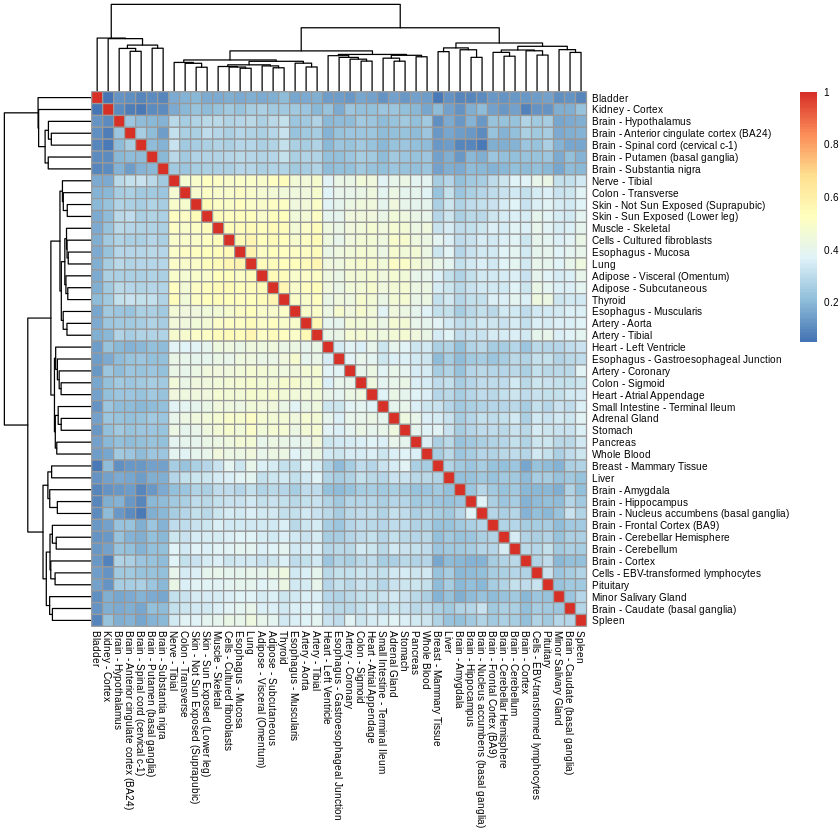

In [257]:
library(pheatmap)
pheatmap(as.matrix(all_se_jc_inc_dist_mat),   fontsize = 6)
hm.parameters <- list(all_se_jc_inc_dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/Figure1cwithrMATS.all_se_jc_inc_PSI.values.pdf"))

## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [96]:
figure_id   = "DEFigurewithrMATS"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data && find . -type f -exec sha256sum {} \\;  >  ../metadata/", figure_id, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

data.table::fread(paste0("../metadata/", figure_id, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

Generating sha256 checksums of the artefacts in the `..data/` directory .. 


character(0)

Done!



sha256sum,file
<chr>,<chr>
80301ccdc5323e378d1a2e644360762b44c2a53f8d96ca26f6c4fc0ea03ca452,./Heart-LeftVentricle_se_jc_inc_as_counts_DGE.csv
ebe1713963cd88e7bb2ac961e7d7209b38d2b0e8136b28fe4425ac8d04ad0b18,./rmats_final.mxe.jcec.skiplen.txt.gz
a69a0f72121d0746e015da13a23aea6a46a05691b1f90cf0177a1b77c5f49de1,./Colon-Sigmoid_se_jc_inc_as_counts_DGE.csv
43096e5730db80217eb9869b25c60bd5336061801cea02009bd646e241b487a8,./Brain-FrontalCortex(BA9)_se_jc_inc_as_counts_DGE.csv
76796c62a25075899ff58ee7b5258b59bdf4eb1b42242579afd86eb9a4cfd10d,./Brain-Putamen(basalganglia)_se_jc_inc_as_counts_DGE.csv
a918d8d065f85b24a787f6013f10881463c0d0975509a8a9ef50b7c2348dc527,./reduced_y.se.jc.inc_as_counts.rds
490afac0f9797126ea051b167f409bbc011a8bdbe190b991ce0da972c5424cbf,./Cells-EBV-transformedlymphocytes_DGE.csv
cbaf828b429e0ef03c87ffa4cd52f7daaf71b0175aae79283c22bb42bda42336,./Colon-Transverse_se_jc_inc_as_counts_DGE.csv
daf29468f41a08053016310958de33d7b210e81c75a52d32c2e49ed17c9e1925,./Spleen_se_jc_inc_as_counts_DGE.csv


### 2. Libraries metadata

In [67]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..
Done!

Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..
Done!



 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-03-10                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
Biobase,Biobase,2.46.0,2.46.0,/opt/conda/lib/R/library/Biobase,/opt/conda/lib/R/library/Biobase,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
BiocGenerics,BiocGenerics,0.32.0,0.32.0,/opt/conda/lib/R/library/BiocGenerics,/opt/conda/lib/R/library/BiocGenerics,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
biomaRt,biomaRt,2.42.0,2.42.0,/opt/conda/lib/R/library/biomaRt,/opt/conda/lib/R/library/biomaRt,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
DBI,DBI,1.1.0,1.1.0,/opt/conda/lib/R/library/DBI,/opt/conda/lib/R/library/DBI,TRUE,FALSE,2019-12-15,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
devtools,devtools,2.0.2,2.0.2,/opt/conda/lib/R/library/devtools,/opt/conda/lib/R/library/devtools,TRUE,FALSE,2019-04-08,CRAN (R 3.6.0),NA,/opt/conda/lib/R/library
downloader,downloader,0.4,0.4,/opt/conda/lib/R/library/downloader,/opt/conda/lib/R/library/downloader,TRUE,FALSE,2015-07-09,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
dplyr,dplyr,0.8.4,0.8.4,/opt/conda/lib/R/library/dplyr,/opt/conda/lib/R/library/dplyr,TRUE,FALSE,2020-01-31,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.1,3.28.1,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2020-02-26,Bioconductor,NA,/opt/conda/lib/R/library
ggplot2,ggplot2,3.2.1,3.2.1,/opt/conda/lib/R/library/ggplot2,/opt/conda/lib/R/library/ggplot2,TRUE,FALSE,2019-08-10,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
